<a href="https://colab.research.google.com/github/gt980103/DLPytorch/blob/master/CIFAR10ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
#使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#设置均值和方差
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
#设置批量大小
batch_size = 32
lr = 0.05
epochs = 150

#设置数据预处理 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

#读取数据集 设置训练集和测试集
train_set = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

def evl_test_acc(test_loader ,model, device = None):
    if device is None and isinstance(model, torch.nn.Module):
        # 如果没指定device就使用model的device
        device = list(model.parameters())[0].device 
    with torch.no_grad():
        model.eval()
        total = 0.0
        correct = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predict = torch.max(outputs,1)
            total += labels.size(0)
            correct += (labels == predict).sum().item()
        model.train()
    return correct / total

import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import time

#model = torchvision.models.resnet50(pretrained=True)
#in_features = model.fc.in_features
#model.fc = nn.Linear(in_features, 10)
model = torchvision.models.resnet18(num_classes = 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=lr)

start_time = time.time()
each_epoch_time = time.time()

test_accs = []
train_accs = []

for epoch in range(epochs):
    running_loss = 0.0
    train_total = 0.0
    train_correct = 0.0
    start = time.time()

    if epoch % 20 == 19:
      lr = lr / 2
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
      #optimizer = optim.Adam(model.parameters(), lr=lr)
    for i,data in enumerate(train_loader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #清空梯度
        optimizer.zero_grad()
        #正向传播 反向传播 更新参数
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        #记录损失
        #running_loss += loss.item()
        
        #训练集数量 训练集正确数量
        train_total += labels.size(0)
        _, predict = torch.max(output.data,1)
        train_correct += (labels == predict).sum().item()      
        #每50组batch 打印一次
        # if i % 50 == 49:
        #     print('[%d, %5d] loss: %.5f train_acc: %.5f time: %.3f sec' % (epoch + 1, i + 1, running_loss / 50, train_correct / train_total ,time.time()-each_epoch_time))
        #     running_loss = 0.0
        #     each_epoch_time = time.time()
    #记录一次epoch的训练误差 测试误差 训练时间
    test_acc = evl_test_acc(test_loader, model)
    test_accs.append(test_acc)
    train_accs.append(train_correct / train_total)
    print('epoch %d, train acc: %.5f, test acc: %.5f, time: %.3f sec'
              % (epoch + 1,  train_correct / train_total, test_acc, time.time() - start))
    print("total time %.3f sec" % (time.time() - start_time))

Files already downloaded and verified
Files already downloaded and verified
epoch 1, train acc: 0.32276, test acc: 0.40920, time: 49.327 sec
total time 49.327 sec
epoch 2, train acc: 0.44718, test acc: 0.47560, time: 49.095 sec
total time 98.422 sec
epoch 3, train acc: 0.52484, test acc: 0.57370, time: 48.304 sec
total time 146.727 sec
epoch 4, train acc: 0.57406, test acc: 0.58340, time: 49.072 sec
total time 195.799 sec
epoch 5, train acc: 0.59908, test acc: 0.65760, time: 48.806 sec
total time 244.605 sec
epoch 6, train acc: 0.62196, test acc: 0.64540, time: 48.709 sec
total time 293.316 sec
epoch 7, train acc: 0.63480, test acc: 0.63340, time: 49.156 sec
total time 342.472 sec
epoch 8, train acc: 0.64848, test acc: 0.69260, time: 49.679 sec
total time 392.153 sec
epoch 9, train acc: 0.65594, test acc: 0.67700, time: 48.586 sec
total time 440.740 sec
epoch 10, train acc: 0.66296, test acc: 0.67880, time: 49.478 sec
total time 490.218 sec
epoch 11, train acc: 0.67060, test acc: 0.663

KeyboardInterrupt: ignored

In [0]:
PATH = './cifar_resnet18.pth'
torch.save(model.state_dict(), PATH)

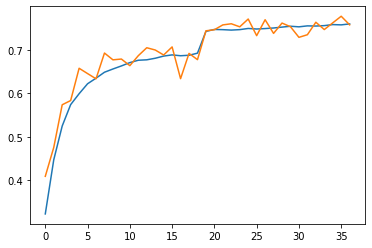

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
x = range(len(train_accs))
plt.plot(x,train_accs)
plt.plot(x,test_accs)
plt.show()